In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [128]:
path = r"C:\Users\VISHNU VARMA\Desktop\SIH\division2"


In [129]:
labels = []
for lab in tqdm(os.listdir(path)):
    labels.append(lab)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]


In [130]:
print(labels)

['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']


In [131]:
X_train = []
y_train = []
image_size = 224

for i in labels:
    folderPath = os.path.join(path, i)
    for j in tqdm(os.listdir(folderPath)):
        try:
            img = cv2.imread(os.path.join(folderPath, j))
            
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X_train.append(img)
                y_train.append(i)
            else:
                print(f"Image {j} in folder {folderPath} could not be loaded.")
        except Exception as e:
            print(f"Error loading image {j} in folder {folderPath}: {e}")


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 78.31it/s]


In [132]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [133]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [134]:
X_train,X_Val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [135]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [136]:

# Convert y_train and y_test to lists if they are NumPy arrays
y_train_list = y_train.tolist() if isinstance(y_train, np.ndarray) else y_train
y_test_list = y_test.tolist() if isinstance(y_test, np.ndarray) else y_test

# Create a mapping of class labels to indices
label_to_index = {str(label): idx for idx, label in enumerate(labels)}

# Convert y_train_list and y_test_list to numerical labels, and handle any discrepancies
y_train_new = [label_to_index.get(str(label), -1) for label in y_train_list]
y_test_new = [label_to_index.get(str(label), -1) for label in y_test_list]

# Check for any labels not found in the label_to_index mapping and handle them as needed

# Remove elements with -1 (labels not found in the label_to_index mapping)
y_train_new = [label_idx for label_idx in y_train_new if label_idx != -1]
y_test_new = [label_idx for label_idx in y_test_new if label_idx != -1]

# Convert y_train_new and y_test_new to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train_new, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test_new, num_classes=len(labels))



# EfficientNetB0

In [137]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [138]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(30,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [139]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("All_EfficientNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [140]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs = 50, verbose=1, batch_size=30,
                   callbacks=[tensorboard,checkpoint,reduce_lr])
    

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 0.6714
Epoch 1: val_accuracy improved from -inf to 0.70339, saving model to All_EfficientNet.h5
36/36 [==============================] - 99s 2s/step - loss: 1.3643 - accuracy: 0.6714 - val_loss: 1.2433 - val_accuracy: 0.7034 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9621
Epoch 2: val_accuracy improved from 0.70339 to 0.83898, saving model to All_EfficientNet.h5
36/36 [==============================] - 77s 2s/step - loss: 0.1475 - accuracy: 0.9621 - val_loss: 0.5937 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9811
Epoch 3: val_accuracy improved from 0.83898 to 0.84746, saving model to All_EfficientNet.h5
36/36 [==============================] - 76s 2s/step - loss: 0.0812 - accuracy: 0.9811 - val_loss: 0.6758 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 4/50
36/36 [=

Epoch 26/50
36/36 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9981
Epoch 26: val_accuracy did not improve from 0.98305
36/36 [==============================] - 77s 2s/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0558 - val_accuracy: 0.9831 - lr: 1.9683e-08
Epoch 27/50
36/36 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9991
Epoch 27: val_accuracy did not improve from 0.98305

Epoch 27: ReduceLROnPlateau reducing learning rate to 5.904900035602622e-09.
36/36 [==============================] - 78s 2s/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 0.0572 - val_accuracy: 0.9831 - lr: 1.9683e-08
Epoch 28/50
36/36 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 0.98305
36/36 [==============================] - 77s 2s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0580 - val_accuracy: 0.9831 - lr: 5.9049e-09
Epoch 29/50
36/36 [========================

In [141]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_10[0][0]']            
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 56, 56, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 56, 56, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 56, 56, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 28, 28, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 28, 28, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 28, 28, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 14, 14, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 14, 14, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 14, 14, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 14, 14, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 14, 14, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 14, 14, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 14, 14, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 14, 14, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 14, 14, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 7, 7, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 7, 7, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 7, 7, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 7, 7, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 7, 7, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d_5  (None, 1280)                 0         ['top_activation[0][0]']      
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 dropout_4

In [142]:
train_acc1 = history.history['accuracy']
train_loss1 = history.history['loss']
val_acc1 = history.history['val_accuracy']
val_loss1 = history.history['val_loss']

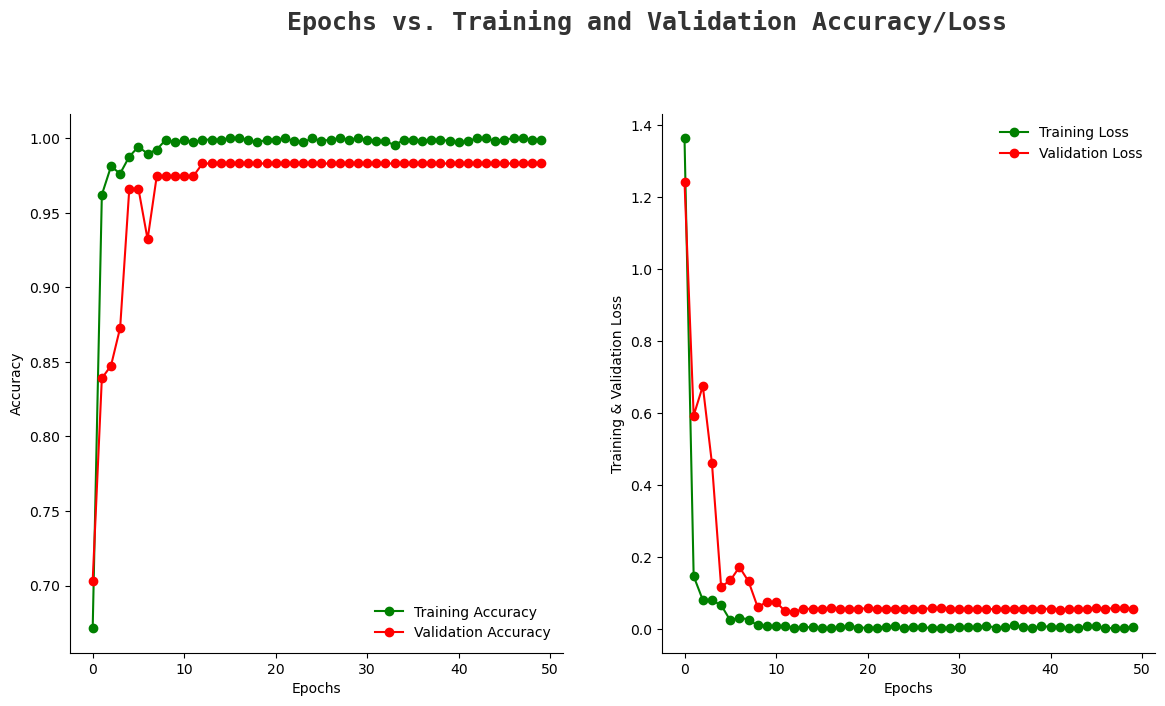

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have defined colors_green and colors_red
colors_green = ['green']  # Replace with your actual color definition
colors_red = ['red']      # Replace with your actual color definition
no_epochs =50
# Make sure the lists have the same length
epochs = [i for i in range(no_epochs)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Modify the title text to use the color 'black' since colors_dark was not defined
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color='black', y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[0], color=colors_green[0],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[0], color=colors_red[0],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[0], color=colors_green[0],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[0], color=colors_red[0],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

plt.show()


In [145]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 6s 510ms/step


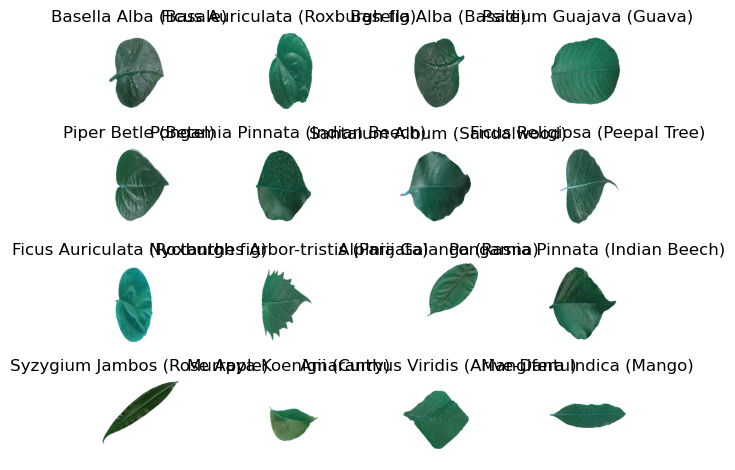

In [146]:
import matplotlib.pyplot as plt

# Get the predicted labels.
pred_lab = []
for p in pred:
    pred_lab.append(labels[p])

# Create a figure and a 4x4 grid of subplots.
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)

# Iterate over the subplots and plot the predicted labels.
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(X_test[i*4+j])
        axs[i, j].set_title(pred_lab[i * 4 + j])
        axs[i, j].axis('off')

# Adjust the subplot layout.
fig.tight_layout() 

# Show the plot.
plt.show()


In [147]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00         9
           7       1.00      0.89      0.94         9
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        11
          12       1.00      0.83      0.91        12
          13       1.00      1.00      1.00        13
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         8
          16       0.90      1.00      0.95         9
          17       0.89    

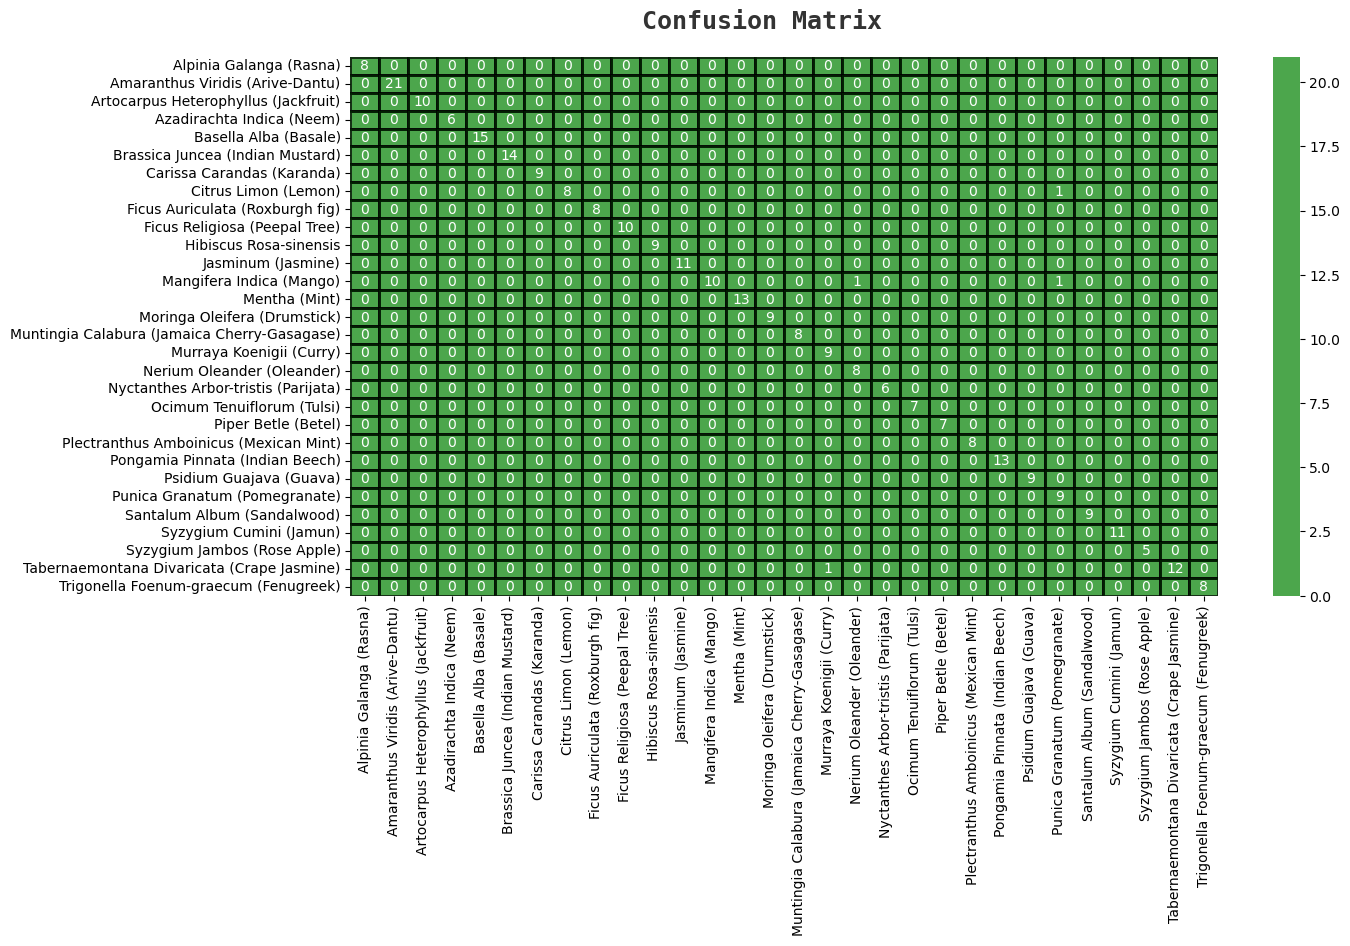

In [148]:
colors_green = ['green']  # Replace with your color definitions
linecolor = 'black'

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
conf_matrix = confusion_matrix(y_test_new, pred)

sns.heatmap(conf_matrix, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=linecolor)
fig.text(s='     Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=linecolor, y=0.92, x=0.28, alpha=0.8)

plt.show()

In [149]:
# Get the train, validation, and test data location
train_data_dir = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\train"
validation_data_dir = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\val"
test_data_dir = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\test"

img_width, img_height = 224, 224
batch_size = 32

100%|██████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]


1/1 [==============================] - 1s 1s/step
Pongamia Pinnata (Indian Beech)
1/1 [==============================] - 0s 103ms/step
Predicted leaf class: Pongamia Pinnata (Indian Beech)
Percentage of prediction: 95.59444785118103


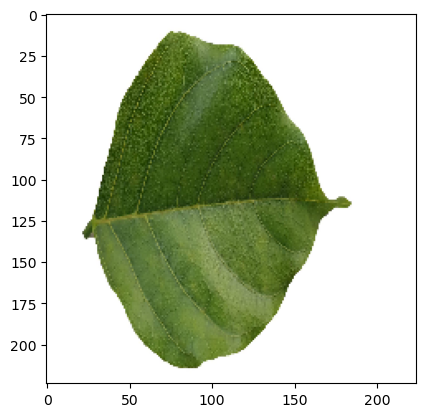

In [150]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os

# Function to load and preprocess an image from a local file
def load_and_preprocess_image(image_path, img_width, img_height):
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array

labels = []
for lab in tqdm(os.listdir(path)):
    labels.append(lab)

# Load the trained model using TensorFlow/Keras
loaded_model = load_model("All_EfficientNet.h5")

# Define the local file path to the image you want to test
image_path = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\test\Pongamia Pinnata (Indian Beech)\PP-S-016.jpg"
# Define the dimensions of your input images (match your model's input size)
img_width, img_height = 160, 160

# Load and preprocess the test image
#input_img, img_array = load_and_preprocess_image(image_path, img_width, img_height)
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


# Make predictions using the loaded model
predictions = loaded_model.predict(img_array)

print(labels[np.argmax(predictions)])
plt.imshow(img)

# Load and preprocess the image.
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions using the loaded model.
predictions = loaded_model.predict(img_array)

# Select the disease class with the highest probability.
predicted_class = labels[np.argmax(predictions)]

# Calculate the percentage of disease.
leaf_percentage = predictions[0][np.argmax(predictions)] * 100

# Print the results.
print("Predicted leaf class:", predicted_class)
print("Percentage of prediction:", leaf_percentage)


In [151]:
# Create data generators with data augmentation for train and validation sets
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1273 images belonging to 30 classes.
Found 356 images belonging to 30 classes.


# MoblieNet_V2

In [154]:

# Build MobileNetV2 base model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Add custom top layers for image classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')  # 'num_classes' is the number of classes in your dataset
])

9406464/9406464 [==============================] - 1s 0us/step


In [155]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Choose an optimizer (e.g., Adam) and specify the learning rate
    loss='categorical_crossentropy',  # Specify the loss function based on your task
    metrics=['accuracy']  # Specify metrics to monitor during training
)
epochs = 50
# Now you can proceed to train your model
history2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/50
40/40 [==============================] - 62s 1s/step - loss: 1.7610 - accuracy: 0.5185 - val_loss: 7.7123 - val_accuracy: 0.0899
Epoch 2/50
40/40 [==============================] - 49s 1s/step - loss: 0.7074 - accuracy: 0.8028 - val_loss: 14.1697 - val_accuracy: 0.0478
Epoch 3/50
40/40 [==============================] - 48s 1s/step - loss: 0.5901 - accuracy: 0.8272 - val_loss: 14.1791 - val_accuracy: 0.0730
Epoch 4/50
40/40 [==============================] - 47s 1s/step - loss: 0.3676 - accuracy: 0.8924 - val_loss: 10.9099 - val_accuracy: 0.1011
Epoch 5/50
40/40 [==============================] - 47s 1s/step - loss: 0.3308 - accuracy: 0.8955 - val_loss: 15.7505 - val_accuracy: 0.0449
Epoch 6/50
40/40 [==============================] - 47s 1s/step - loss: 0.3289 - accuracy: 0.9065 - val_loss: 17.1117 - val_accuracy: 0.0421
Epoch 7/50
40/40 [==============================] - 47s 1s/step - loss: 0.3724 - accuracy: 0.9026 - val_loss: 19.9293 - val_accuracy: 0.0281
Epoch 8/50
40/

In [156]:
# Save the trained model for future use
model.save('All_MoblieNetV2.h5')


C:\Users\VISHNU VARMA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [157]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_37 (Dense)            (None, 512)               655872    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 30)                15390     
                                                                 
Total params: 2929246 (11.17 MB)
Trainable params: 28

In [158]:
train_acc2 = history2.history['accuracy']
train_loss2 = history2.history['loss']
val_acc2 = history2.history['val_accuracy']
val_loss2 = history2.history['val_loss']

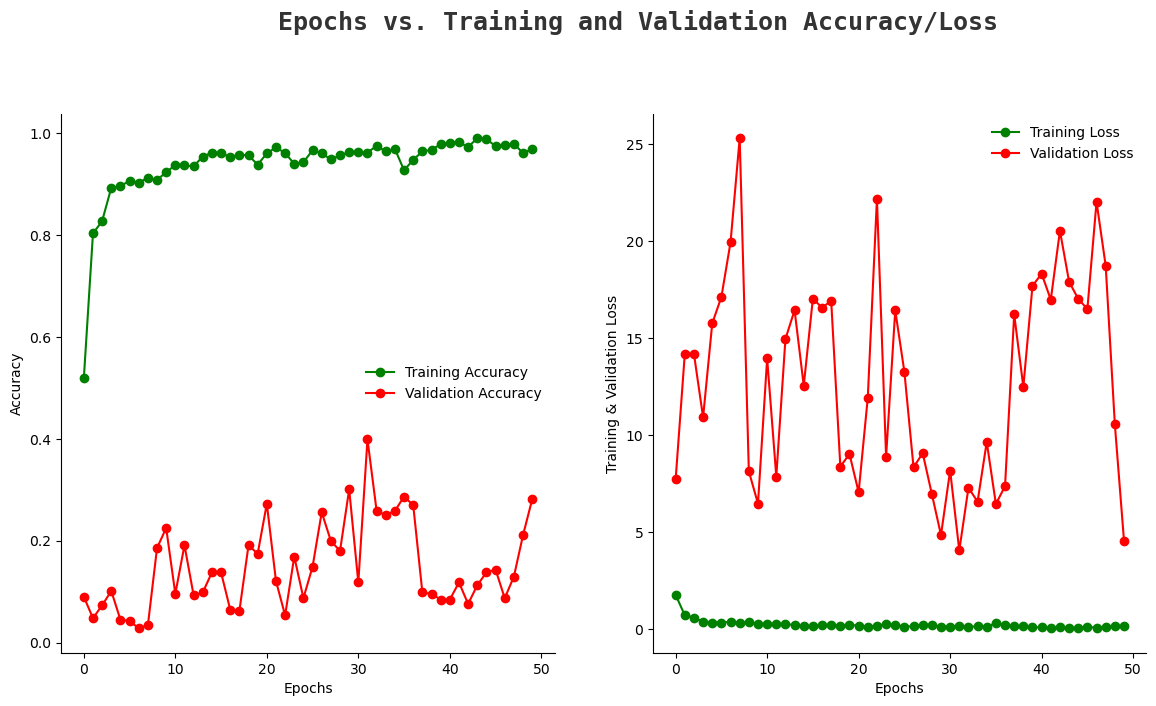

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have defined colors_green and colors_red
colors_green = ['green']  # Replace with your actual color definition
colors_red = ['red']      # Replace with your actual color definition

# Make sure the lists have the same length
epochs = [i for i in range(epochs)]
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

# Modify the title text to use the color 'black' since colors_dark was not defined
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color='black', y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[0], color=colors_green[0],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[0], color=colors_red[0],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[0], color=colors_green[0],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[0], color=colors_red[0],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

plt.show()


In [161]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('All_MoblieNetV2.h5')

# Function to preprocess an image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Make predictions on new images
image_path_1 = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\val\Azadirachta Indica (Neem)\AI-S-010.jpg"

img_array_1 = preprocess_image(image_path_1)

predictions_1 = model.predict(img_array_1)

# Manually decode predictions
labels = ['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']  # Replace with your actual class labels

# Get the top prediction for each image
top_prediction_1 = labels[np.argmax(predictions_1)]

print("Top Prediction for:", top_prediction_1)


1/1 [==============================] - 1s 581ms/step
Top Prediction for: Azadirachta Indica (Neem)


# DenseNet 

In [162]:
def build_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


num_classes = 30

In [163]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_folder = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\train"
valid_folder = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\test"


batch_size = 30
image_size = (224, 224)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


valid_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


valid_generator = valid_datagen.flow_from_directory(
    valid_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1273 images belonging to 30 classes.
Found 206 images belonging to 30 classes.


In [164]:
import numpy as np

# Example data for X_train (features) and y_train (labels)
# Replace this with your actual data
X_train_data = np.random.rand(100, 224,224, 3)  # Example: 100 images of size 64x64 with 3 channels
y_train_data = np.random.randint(0, 2, size=(100,))  # Example: Binary labels (0 or 1)

# Define the variables
X_train = np.array(X_train_data)
y_train = np.array(y_train_data)


In [165]:

# Convert y_train and y_test to lists if they are NumPy arrays
y_train_list = y_train.tolist() if isinstance(y_train, np.ndarray) else y_train
y_test_list = y_test.tolist() if isinstance(y_test, np.ndarray) else y_test

# Create a mapping of class labels to indices
label_to_index = {str(label): idx for idx, label in enumerate(labels)}

# Convert y_train_list and y_test_list to numerical labels, and handle any discrepancies
y_train_new = [label_to_index.get(str(label), -1) for label in y_train_list]
y_test_new = [label_to_index.get(str(label), -1) for label in y_test_list]

# Check for any labels not found in the label_to_index mapping and handle them as needed

# Remove elements with -1 (labels not found in the label_to_index mapping)
y_train_new = [label_idx for label_idx in y_train_new if label_idx != -1]
y_test_new = [label_idx for label_idx in y_test_new if label_idx != -1]

# Convert y_train_new and y_test_new to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train_new, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test_new, num_classes=len(labels))



In [166]:
img_width, img_height = 224, 224

# Build MobileNetV2 base model (pre-trained on ImageNet)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom top layers for image classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')  # 'num_classes' is the number of classes in your dataset
])

In [167]:
base_model_dense = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_dense = build_model(base_model_dense, num_classes)


In [168]:
train_labels_one_hot = to_categorical(train_generator.labels, num_classes)
valid_labels_one_hot = to_categorical(valid_generator.labels, num_classes)

model_dense.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [169]:
history3 = model_dense.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size,
               validation_data=valid_generator, validation_steps=valid_generator.samples // batch_size,
               epochs=50)



Epoch 1/50
42/42 [==============================] - 170s 3s/step - loss: 1.3475 - accuracy: 0.6307 - val_loss: 6.0625 - val_accuracy: 0.0667
Epoch 2/50
42/42 [==============================] - 141s 3s/step - loss: 0.6090 - accuracy: 0.8061 - val_loss: 9.8826 - val_accuracy: 0.1111
Epoch 3/50
42/42 [==============================] - 140s 3s/step - loss: 0.3909 - accuracy: 0.8842 - val_loss: 3.8064 - val_accuracy: 0.3444
Epoch 4/50
42/42 [==============================] - 139s 3s/step - loss: 0.3395 - accuracy: 0.8946 - val_loss: 3.8408 - val_accuracy: 0.3833
Epoch 5/50
42/42 [==============================] - 139s 3s/step - loss: 0.2327 - accuracy: 0.9187 - val_loss: 1.8605 - val_accuracy: 0.7167
Epoch 6/50
42/42 [==============================] - 140s 3s/step - loss: 0.3081 - accuracy: 0.9043 - val_loss: 11.1857 - val_accuracy: 0.1611
Epoch 7/50
42/42 [==============================] - 140s 3s/step - loss: 0.2858 - accuracy: 0.9147 - val_loss: 7.3092 - val_accuracy: 0.3167
Epoch 8/50
4

In [173]:
model_dense.save("All_DenseNet.h5")

In [174]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_7  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_39 (Dense)            (None, 512)               524800    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 30)                15390     
                                                                 
Total params: 7577694 (28.91 MB)
Trainable params: 7494046 (28.59 MB)
Non-trainable params: 83648 (326.75 KB)
_________

In [175]:
train_acc3 = history3.history['accuracy']
train_loss3 = history3.history['loss']
val_acc3 = history3.history['val_accuracy']
val_loss3 = history3.history['val_loss']

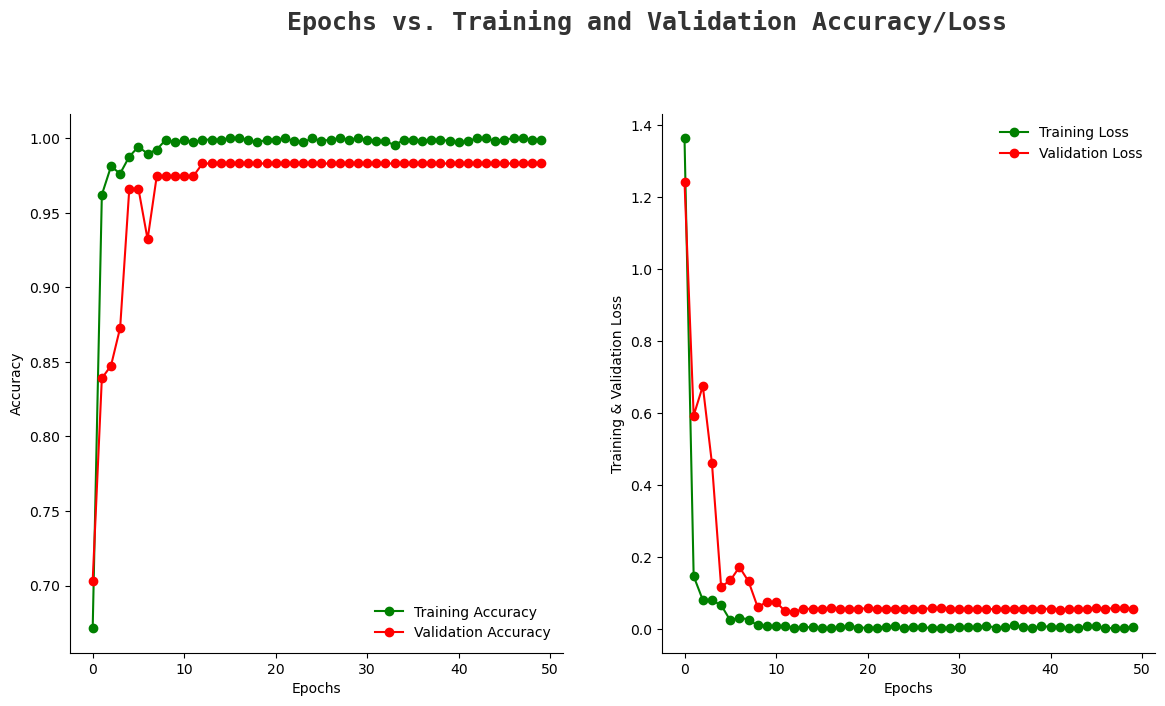

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have defined colors_green and colors_red
colors_green = ['green']  # Replace with your actual color definition
colors_red = ['red']      # Replace with your actual color definition
no_epochs = 50
# Make sure the lists have the same length
epochs = [i for i in range(no_epochs)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Modify the title text to use the color 'black' since colors_dark was not defined
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color='black', y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[0], color=colors_green[0],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[0], color=colors_red[0],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[0], color=colors_green[0],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[0], color=colors_red[0],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

plt.show()


1/1 [==============================] - 1s 1s/step
Mentha (Mint)
1/1 [==============================] - 0s 79ms/step
Predicted leaf class: Mentha (Mint)
Percentage of prediction: 100.0


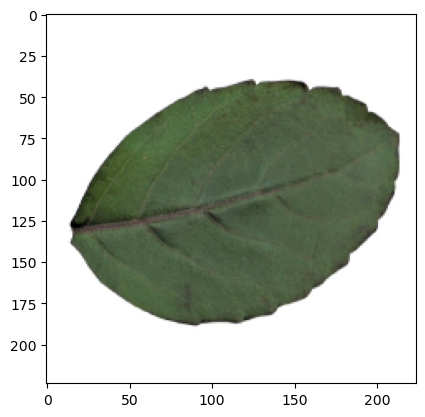

In [177]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os

# Function to load and preprocess an image from a local file
def load_and_preprocess_image(image_path, img_width, img_height):
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array



# Load the trained model using TensorFlow/Keras
loaded_model = load_model("All_DenseNet.h5")

# Define the local file path to the image you want to test
image_path = r"C:\Users\VISHNU VARMA\Desktop\SIH\split\val\Ocimum Tenuiflorum (Tulsi)\OT-S-006.jpg"
# Define the dimensions of your input images (match your model's input size)
img_width, img_height = 160, 160

# Load and preprocess the test image
#input_img, img_array = load_and_preprocess_image(image_path, img_width, img_height)
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


# Make predictions using the loaded model
predictions = loaded_model.predict(img_array)

print(labels[np.argmax(predictions)])
plt.imshow(img)

# Load and preprocess the image.
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions using the loaded model.
predictions = loaded_model.predict(img_array)

# Select the disease class with the highest probability.
predicted_class = labels[np.argmax(predictions)]

# Calculate the percentage of disease.
leaf_percentage = predictions[0][np.argmax(predictions)] * 100

# Print the results.
print("Predicted leaf class:", predicted_class)
print("Percentage of prediction:", leaf_percentage)


# comparison between three models 

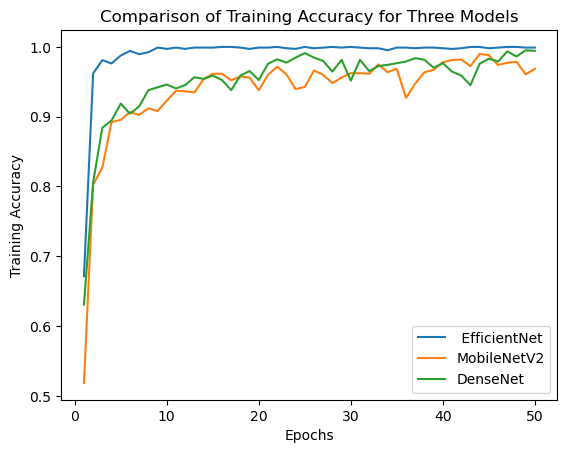

In [179]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have training accuracy for three models
epochs = range(1, len(train_acc1) + 1)
train_acc1 = history.history['accuracy']
train_acc2 = history2.history['accuracy']
train_acc3 = history3.history['accuracy']

fig, ax = plt.subplots()

# Plotting the training accuracy for Model 1
ax.plot(epochs, train_acc1, label=' EfficientNet')

# Plotting the training accuracy for Model 2
ax.plot(epochs, train_acc2, label='MobileNetV2')

# Plotting the training accuracy for Model 3
ax.plot(epochs, train_acc3, label='DenseNet')

# Adding labels, title, and legend
ax.set_xlabel('Epochs')
ax.set_ylabel('Training Accuracy')
ax.set_title('Comparison of Training Accuracy for Three Models')
ax.legend()

# Display the plot
plt.show()


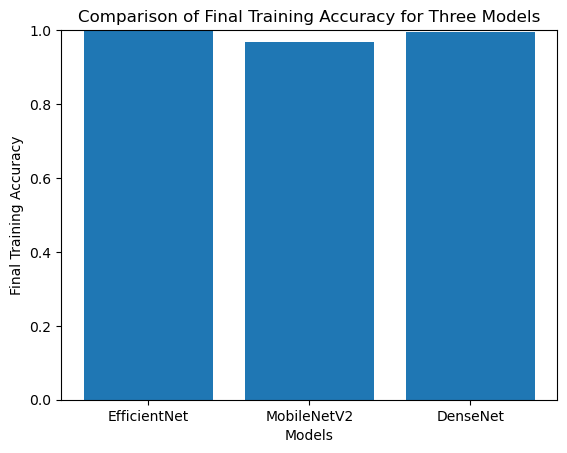

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have final training accuracy for three models
final_train_acc1 = train_acc1[-1]
final_train_acc2 = train_acc2[-1]
final_train_acc3 = train_acc3[-1]

# Model names
models = ['EfficientNet', 'MobileNetV2', 'DenseNet']

# Bar chart
plt.bar(models, [final_train_acc1, final_train_acc2, final_train_acc3])
plt.xlabel('Models')
plt.ylabel('Final Training Accuracy')
plt.title('Comparison of Final Training Accuracy for Three Models')
plt.ylim(0, 1)  # Set y-axis limit to match accuracy scale (0 to 1)
plt.show()


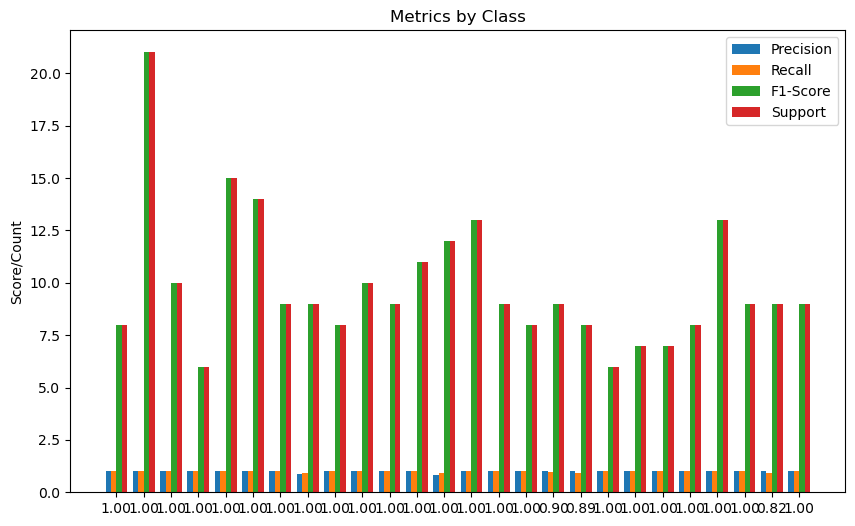

In [183]:
import matplotlib.pyplot as plt

# Example classification report
classification_rep = '''
             precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00         9
           7       1.00      0.89      0.94         9
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        11
          12       1.00      0.83      0.91        12
          13       1.00      1.00      1.00        13
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         8
          16       0.90      1.00      0.95         9
          17       0.89      1.00      0.94         8
          18       1.00      1.00      1.00         6
          19       1.00      1.00      1.00         7
          20       1.00      1.00      1.00         7
          21       1.00      1.00      1.00         8
          22       1.00      1.00      1.00        13
          23       1.00      1.00      1.00         9
          24       0.82      1.00      0.90         9
          25       1.00      1.00      1.00         9
          26       1.00      1.00      1.00        11
          27       1.00      1.00      1.00         5
          28       1.00      0.92      0.96        13
          29       1.00      1.00      1.00         8
'''

# Parse the classification report
lines = classification_rep.split('\n')

# Check if there are enough lines to parse
if len(lines) >= 6:
    class_names = [line.split()[1] for line in lines[2:-5] if line.strip()]
    precision = [float(line.split()[2]) for line in lines[2:-5] if line.strip()]
    recall = [float(line.split()[3]) for line in lines[2:-5] if line.strip()]
    f1_score = [float(line.split()[4]) for line in lines[2:-5] if line.strip()]
    support = [int(line.split()[-1]) for line in lines[2:-5] if line.strip()]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.2
    x = range(len(class_names))
    ax.bar(x, precision, width, label='Precision')
    ax.bar([i + width for i in x], recall, width, label='Recall')
    ax.bar([i + 2 * width for i in x], f1_score, width, label='F1-Score')
    ax.bar([i + 3 * width for i in x], support, width, label='Support')

    ax.set_xticks([i + 1.5 * width for i in x])
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.set_title('Metrics by Class')
    ax.set_ylabel('Score/Count')
    plt.show()
else:
    print("Invalid classification report format.")
